<a href="https://colab.research.google.com/github/badabheem/Biological_SEQ/blob/main/Blinding_Docking_INTERACTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Automated Workflow for Blind Docking

In [3]:
# Install dependencies
!apt-get install -y openbabel
!pip install -q biopython pubchempy py3Dmol
!pip install -q rdkit

# Download AutoDock Vina
import os
if not os.path.exists("vina"):
    !wget -q https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.5/vina_1.2.5_linux_x86_64 -O vina
    !chmod +x vina

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openbabel is already the newest version (3.1.1+dfsg-6ubuntu5).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [16]:
# Define Targets
PDB_ID = "6COX" # @param {type:"string"}
PUBCHEM_ID = "" # @param {type:"string"}
SMILES = "C[C@@H]3CCC(=NC1=CC=CC=C1N=C(CCC(=NC2=CC=CC=C2N3)C)C)C" # @param {type:"string"}

print(f"Target: PDB {PDB_ID} | Ligand CID {PUBCHEM_ID} | SMILES {SMILES}")

Target: PDB 6COX | Ligand CID  | SMILES C[C@@H]3CCC(=NC1=CC=CC=C1N=C(CCC(=NC2=CC=CC=C2N3)C)C)C


In [17]:
import pubchempy as pcp
from Bio.PDB import PDBList, PDBParser, PDBIO, Select
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem

CHAINS_TO_KEEP = "['A']" # @param {type:"string"}

# Prepare Ligand
ligand_file_base = None
if SMILES:
    print(f"Preparing Ligand from SMILES: {SMILES}")
    mol = Chem.MolFromSmiles(SMILES)
    if mol:
        AllChem.EmbedMolecule(mol, AllChem.ETKDGv2())
        AllChem.UFFOptimizeMolecule(mol)
        ligand_file_base = "ligand_from_smiles"
        writer = Chem.SDWriter(f'{ligand_file_base}.sdf')
        writer.write(mol)
        writer.close()
        !obabel {ligand_file_base}.sdf -O {ligand_file_base}.pdbqt --gen3d -h --partialcharge gasteiger 2> /dev/null
    else:
        print("Error: Could not create molecule from SMILES.")
        ligand_file_base = None
elif PUBCHEM_ID:
    print(f"Preparing Ligand from PubChem ID: {PUBCHEM_ID}")
    ligand_file_base = f"ligand_{PUBCHEM_ID}"
    pcp.download('SDF', f'{ligand_file_base}.sdf', PUBCHEM_ID, 'cid', overwrite=True, record_type='3d')
    !obabel {ligand_file_base}.sdf -O {ligand_file_base}.pdbqt --gen3d -h --partialcharge gasteiger 2> /dev/null
else:
    raise ValueError("No ligand provided. Please specify either a PubChem ID or a SMILES string.")

receptor_name = f"receptor_{PDB_ID}"

print(f"Downloading Receptor {PDB_ID}...")
pdbl = PDBList()
pdbl.retrieve_pdb_file(PDB_ID, pdir='.', file_format='pdb', overwrite=True)
raw_pdb = f"pdb{PDB_ID.lower()}.ent"

class ComplexSelect(Select):
    def accept_chain(self, chain):
        return 1 if chain.id in CHAINS_TO_KEEP else 0

    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

parser = PDBParser(QUIET=True)
structure = parser.get_structure(PDB_ID, raw_pdb)
io = PDBIO()
io.set_structure(structure)
io.save(f"{receptor_name}.pdb", ComplexSelect())

print(f"Converting Chains {CHAINS_TO_KEEP} to PDBQT...")
!obabel {receptor_name}.pdb -O {receptor_name}.pdbqt -xr -h --partialcharge gasteiger 2> /dev/null

# Update ligand_name for downstream cells if successful
if ligand_file_base:
    ligand_name = ligand_file_base
else:
    ligand_name = None # Indicate no ligand was successfully prepared

Preparing Ligand from SMILES: C[C@@H]3CCC(=NC1=CC=CC=C1N=C(CCC(=NC2=CC=CC=C2N3)C)C)C


[09:53:56] Molecule does not have explicit Hs. Consider calling AddHs()
[09:53:56] Molecule does not have explicit Hs. Consider calling AddHs()


Converting Chains ['A'] to PDBQT...


In [18]:
#Calculate Grid Box for blind docking

import numpy as np
from Bio.PDB import PDBParser

def get_coords(pdb_file):
    structure = PDBParser(QUIET=True).get_structure('struct', pdb_file)
    return np.array([atom.get_coord() for atom in structure.get_atoms()])

# Calculate Center of Mass and Dimensions
coords = get_coords(f"{receptor_name}.pdb")
center = coords.mean(axis=0)
size = (coords.max(axis=0) - coords.min(axis=0)) + 10  # 10Å buffer

print(f"Grid Center: {center}\nGrid Size: {size}")

Grid Center: [27.732147 29.435076 40.185833]
Grid Size: [68.037    83.955    73.371994]


In [19]:
# Run AutoDock Vina

# Write Config File
config = f"""
receptor = {receptor_name}.pdbqt
ligand = {ligand_name}.pdbqt
center_x = {center[0]:.3f}
center_y = {center[1]:.3f}
center_z = {center[2]:.3f}
size_x = {size[0]:.3f}
size_y = {size[1]:.3f}
size_z = {size[2]:.3f}
num_modes = 9
exhaustiveness = 8
cpu = 2
"""
# Adjust adjustivness for faster dockin
with open("config.txt", "w") as f: f.write(config)

# Run Docking
output_file = f"{PDB_ID}_{PUBCHEM_ID}_docked.pdbqt"
log_file = "docking_log.txt"
!./vina --config config.txt --out {output_file} > {log_file}

print("Docking complete.")

Docking complete.


In [21]:
log_file = "docking_log.txt"
output_file = f"{PDB_ID}_{PUBCHEM_ID}_docked.pdbqt"

# Parse and print binding affinities
with open(log_file, 'r') as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    if line.strip().startswith("1") and "kcal/mol" not in line:
        print("".join(lines[i-3:i+5]))
        break

# Split poses (Output: pose1.pdb, pose2.pdb...)
!obabel -ipdbqt {output_file} -opdb -O pose.pdb -m 2> /dev/null

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.751          0          0
   2       -7.735      25.05      28.94
   3       -7.548      41.89      44.24
   4       -7.424      24.07         27
   5       -7.403      31.38       34.2



In [22]:
# Visualziation

import py3Dmol

with open(f"{receptor_name}.pdb") as f: receptor_data = f.read()
with open("pose1.pdb") as f: ligand_data = f.read()

view = py3Dmol.view(width=1200, height=400, linked=False, viewergrid=(1,3))

# Overview
view.addModel(receptor_data, 'pdb', viewer=(0,0))
view.setStyle({'model': -1}, {'cartoon': {'color': 'spectrum'}}, viewer=(0,0))
view.addModel(ligand_data, 'pdb', viewer=(0,0))
view.setStyle({'model': -1}, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.5}}, viewer=(0,0))
view.zoomTo(viewer=(0,0))
view.addLabel("Overview", {'position': {'x':0, 'y':0, 'z':0}, 'useScreen': True, 'fontColor':'black', 'backgroundColor':'white'}, viewer=(0,0))

# Surface (Pocket Fit)
view.addModel(receptor_data, 'pdb', viewer=(0,1))
view.setStyle({'model': -1}, {}, viewer=(0,1))
view.addSurface(py3Dmol.SES, {'opacity': 0.8, 'color': 'white'}, viewer=(0,1))

view.addModel(ligand_data, 'pdb', viewer=(0,1))
view.setStyle({'model': -1}, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.5}}, viewer=(0,1))
view.zoomTo(viewer=(0,1))
view.addLabel("Surface Fit", {'position': {'x':0, 'y':0, 'z':0}, 'useScreen': True, 'fontColor':'black', 'backgroundColor':'white'}, viewer=(0,1))

# Ligand Centered
view.addModel(receptor_data, 'pdb', viewer=(0,2))
view.addModel(ligand_data, 'pdb', viewer=(0,2))
view.setStyle({'model': 0}, {'cartoon': {'color': 'gray', 'opacity': 0.5}}, viewer=(0,2))
view.setStyle({'model': 1}, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.5}}, viewer=(0,2))
view.addStyle({'within':{'distance': 5, 'sel':{'model':1}}},
              {'stick':{'colorscheme':'element', 'radius':0.2}}, viewer=(0,2))

view.zoomTo({'model': 1}, viewer=(0,2))
view.addLabel("Interactions (<5Å)", {'position': {'x':0, 'y':0, 'z':0}, 'useScreen': True, 'fontColor':'black', 'backgroundColor':'white'}, viewer=(0,2))

view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [23]:
# Analyze Interactions
import numpy as np
from Bio.PDB import PDBParser, Selection, NeighborSearch

print("🔬 Analyzing Interactions using Biopython...")

parser = PDBParser(QUIET=True)
structure = parser.get_structure('complex', f"{receptor_name}.pdb")
ligand_structure = parser.get_structure('ligand', "pose1.pdb")

protein_atoms = [atom for atom in structure.get_atoms() if atom.get_parent().id[0] == ' ']
ligand_atoms = [atom for atom in ligand_structure.get_atoms()]

ns = NeighborSearch(protein_atoms)

# Define Interaction Thresholds
STRONG_CUTOFF = 3.5  # Angstroms (Hydrogen bonds, Salt bridges)
WEAK_CUTOFF = 5.0    # Angstroms (Hydrophobic, VdW)

interactions = {}

print("-" * 60)
print(f"   INTERACTION REPORT: {PUBCHEM_ID} (Docked Pose)")
print("-" * 60)


for lig_atom in ligand_atoms:
    close_atoms = ns.search(lig_atom.get_coord(), WEAK_CUTOFF)

    for prot_atom in close_atoms:
        distance = lig_atom - prot_atom
        res = prot_atom.get_parent()
        res_id = f"{res.resname}{res.id[1]} ({res.get_parent().id})"
        if res_id not in interactions:
            interactions[res_id] = {'dist': distance, 'type': 'Weak'}

        if distance < interactions[res_id]['dist']:
            interactions[res_id]['dist'] = distance

        if distance < STRONG_CUTOFF:
            interactions[res_id]['type'] = 'Strong (H-Bond/Ionic)'

sorted_interactions = sorted(interactions.items(), key=lambda x: x[1]['dist'])

print(f"{'RESIDUE':<20} | {'DIST (Å)':<10} | {'TYPE'}")
print("-" * 50)

if len(sorted_interactions) == 0:
    print("No interactions found within 5.0 Å.")
else:
    for res, data in sorted_interactions:
        print(f"{res:<20} | {data['dist']:.2f}       | {data['type']}")

print("-" * 60)

🔬 Analyzing Interactions using Biopython...
------------------------------------------------------------
   INTERACTION REPORT:  (Docked Pose)
------------------------------------------------------------
RESIDUE              | DIST (Å)   | TYPE
--------------------------------------------------
SER579 (A)           | 3.77       | Weak
ASN581 (A)           | 4.99       | Weak
------------------------------------------------------------


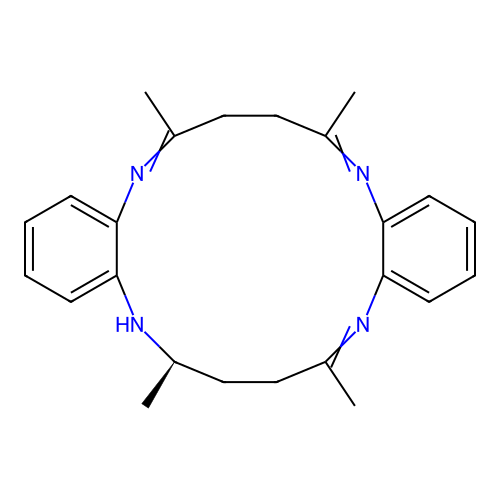

In [24]:
# Generate 2D Ligand Image

from rdkit import Chem
from rdkit.Chem import Draw, AllChem

mol = Chem.MolFromMolFile(f"{ligand_name}.sdf")
AllChem.Compute2DCoords(mol)
img = Draw.MolToImage(mol, size=(500, 500))

display(img)
img.save(f"{PUBCHEM_ID}_2D_structure.png")

# Task
The previous steps have identified the receptor and ligand, performed blind docking, and analyzed the ligand-receptor interactions, presenting a list of interacting residues and their distances.

To provide a more insightful visualization, the next step is to generate a 3D view using `py3Dmol` that specifically highlights these identified interactions. This involves:
1.  **Preparing Interaction Data**: Re-evaluating the detailed atomic interactions to identify the specific ligand atoms and receptor residues involved.
2.  **Generating 3D Visualization**: Using `py3Dmol` to load the receptor and the docked ligand, and then styling the interacting parts based on the prepared data. The visualization will be centered on the interaction site.

First, I'll prepare the interaction data to specifically target the atoms and residues for highlighting in `py3Dmol`.

```python
import py3Dmol
from Bio.PDB import PDBParser, NeighborSearch
import numpy as np

# Re-load necessary data as the kernel might have reset variables if ran independently
parser = PDBParser(QUIET=True)
receptor_structure = parser.get_structure('complex', f"{receptor_name}.pdb")
ligand_structure = parser.get_structure('ligand', "pose1.pdb")

protein_atoms = [atom for atom in receptor_structure.get_atoms() if atom.get_parent().id[0] == ' ']
ligand_atoms = [atom for atom in ligand_structure.get_atoms()]

ns = NeighborSearch(protein_atoms)

# Store all atomic interactions with detailed info
all_atomic_interactions_detailed = []

# Define Interaction Thresholds (from previous analysis)
STRONG_CUTOFF = 3.5  # Angstroms (Hydrogen bonds, Salt bridges)
WEAK_CUTOFF = 5.0    # Angstroms (Hydrophobic, VdW)

for lig_atom in ligand_atoms:
    # Get serial number for py3Dmol selection (py3Dmol uses 1-based serial numbers from PDB)
    lig_atom_serial = lig_atom.get_serial_number()

    close_protein_atoms = ns.search(lig_atom.get_coord(), WEAK_CUTOFF)

    for prot_atom in close_protein_atoms:
        distance = lig_atom - prot_atom
        res = prot_atom.get_parent()
        chain_id = res.get_parent().id
        res_id_tuple = res.id # (hetero_flag, sequence_identifier, insertion_code)
        res_name = res.resname
        res_seq = res_id_tuple[1]

        # Determine interaction type
        interaction_type = 'Weak'
        if distance < STRONG_CUTOFF:
            interaction_type = 'Strong (H-Bond/Ionic)'

        all_atomic_interactions_detailed.append({
            'lig_atom_obj': lig_atom,
            'lig_atom_serial': lig_atom_serial,
            'prot_atom_obj': prot_atom,
            'receptor_res_obj': res,
            'receptor_res_name': res_name,
            'receptor_res_seq': res_seq,
            'receptor_chain_id': chain_id,
            'distance': distance,
            'type': interaction_type
        })

# Consolidate and identify unique interacting residues and ligand atoms
interacting_receptor_residues = {} # { (chain_id, res_name, res_seq): min_distance }
interacting_ligand_atom_serials = set() # {serial_number}

# Also, create a list to store details for the text summary
interaction_summary_details = []

for interaction in all_atomic_interactions_detailed:
    res_key = (interaction['receptor_chain_id'], interaction['receptor_res_name'], interaction['receptor_res_seq'])
    current_min_dist = interacting_receptor_residues.get(res_key, {'distance': np.inf})['distance']

    if interaction['distance'] < current_min_dist:
        interacting_receptor_residues[res_key] = {
            'distance': interaction['distance'],
            'type': interaction['type']
        }
    interacting_ligand_atom_serials.add(interaction['lig_atom_serial'])

    interaction_summary_details.append(
        f"Ligand Atom {interaction['lig_atom_serial']} ({interaction['lig_atom_obj'].name}) with "
        f"Receptor {interaction['receptor_res_name']}{interaction['receptor_res_seq']} ({interaction['receptor_chain_id']}) "
        f"at {interaction['distance']:.2f} Å ({interaction['type']})"
    )

print("Identified Interacting Receptor Residues:")
receptor_res_selections = []
for (chain_id, res_name, res_seq), details in interacting_receptor_residues.items():
    print(f"  - {res_name}{res_seq} (Chain {chain_id}): {details['distance']:.2f} Å ({details['type']})")
    receptor_res_selections.append({'resn': res_name, 'resi': res_seq, 'chain': chain_id})

print("\nIdentified Interacting Ligand Atom Serials:")
print(f"  - {sorted(list(interacting_ligand_atom_serials))}")

# Now, generate the 3D visualization using py3Dmol
# Re-read receptor and ligand data for py3Dmol
with open(f"{receptor_name}.pdb") as f: receptor_data = f.read()
with open("pose1.pdb") as f: ligand_data = f.read()

view = py3Dmol.view(width=800, height=600)

# Add receptor
view.addModel(receptor_data, 'pdb')
view.setStyle({'cartoon': {'color': 'gray'}}) # General receptor style

# Highlight interacting receptor residues
for sel in receptor_res_selections:
    view.addStyle(sel, {'stick': {'colorscheme': 'element', 'radius': 0.2}})
    view.addStyle(sel, {'sphere': {'colorscheme': 'element', 'radius': 0.3}}) # Add spheres for backbone/sidechain
    view.addSurface(py3Dmol.SES, {'opacity': 0.5, 'color': 'white'}, sel=sel) # Surface for interacting residues

# Add ligand
view.addModel(ligand_data, 'pdb')
view.setStyle({'model': 1}, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.5}}) # General ligand style

# Highlight interacting ligand atoms
if interacting_ligand_atom_serials:
    ligand_highlight_selection = {'model': 1, 'serial': list(interacting_ligand_atom_serials)}
    view.addStyle(ligand_highlight_selection, {'stick': {'colorscheme': 'redCarbon', 'radius': 0.6}})
    view.addStyle(ligand_highlight_selection, {'sphere': {'colorscheme': 'redCarbon', 'radius': 0.4}})

# Center the view on the interaction site (using the ligand's center)
view.zoomTo({'model': 1}) # Zoom to the ligand

view.addLabel("Interactions Highlighted", {'position': {'x':0, 'y':0, 'z':0}, 'useScreen': True, 'fontColor':'black', 'backgroundColor':'white'})

view.show()

print("\n--- Detailed Interaction Summary ---")
for detail in interaction_summary_details:
    print(detail)
print("------------------------------------")
```

## Prepare Interaction Data for 3D Visualization

### Subtask:
Re-evaluate the ligand-receptor interactions to identify the specific atoms and residues involved. This data will be used to highlight and style the interacting parts in the 3D visualization.


**Reasoning**:
The subtask requires re-evaluating ligand-receptor interactions to identify specific atoms and residues for 3D visualization. This code block will perform all the necessary steps outlined in the instructions, including loading structures, defining cutoffs, finding interactions, storing detailed data, and consolidating information for both receptor residues and ligand atoms.



In [33]:
import numpy as np
from Bio.PDB import PDBParser, Selection, NeighborSearch

print("\n--- Re-evaluating Interactions for 3D Visualization ---")

# Reload receptor and ligand structures
parser = PDBParser(QUIET=True)
receptor_structure = parser.get_structure('receptor', f"{receptor_name}.pdb")
ligand_structure = parser.get_structure('ligand', "pose1.pdb")

# Extract all protein atoms from the receptor structure
protein_atoms = Selection.unfold_entities(receptor_structure, 'A') # 'A' for atom
# Extract all ligand atoms from the ligand structure
ligand_atoms = Selection.unfold_entities(ligand_structure, 'A') # 'A' for atom

# Initialize NeighborSearch object with protein atoms
ns = NeighborSearch(protein_atoms)

# Define interaction thresholds
STRONG_CUTOFF = 3.5  # Angstroms (Hydrogen bonds, Salt bridges)
WEAK_CUTOFF = 5.0    # Angstroms (Hydrophobic, VdW)

# List to store detailed atomic interactions
all_atomic_interactions_detailed = []

# Iterate through each ligand atom to find interactions
for lig_atom_idx, lig_atom in enumerate(ligand_atoms):
    # Find close protein atoms within WEAK_CUTOFF distance
    close_protein_atoms = ns.search(lig_atom.get_coord(), WEAK_CUTOFF)

    for prot_atom in close_protein_atoms:
        distance = lig_atom - prot_atom
        receptor_res_obj = prot_atom.get_parent()
        receptor_chain_obj = receptor_res_obj.get_parent()

        # Determine interaction type based on distance
        interaction_type = 'Weak'
        if distance <= STRONG_CUTOFF:
            interaction_type = 'Strong'

        all_atomic_interactions_detailed.append({
            'lig_atom_obj': lig_atom,
            'lig_atom_serial': lig_atom.get_id(),
            'lig_atom_rdkit_idx': lig_atom_idx, # RDKit atom index for original molecule
            'prot_atom_obj': prot_atom,
            'receptor_res_obj': receptor_res_obj,
            'receptor_res_name': receptor_res_obj.get_resname(),
            'receptor_res_id_tuple': receptor_res_obj.get_id(), # (hetfield, sequence number, insertion code)
            'receptor_res_seq': receptor_res_obj.get_id()[1],
            'receptor_chain_id': receptor_chain_obj.get_id(),
            'distance': distance,
            'interaction_type': interaction_type
        })

# Consolidate interactions for unique interacting receptor residues
unique_interacting_receptor_residues = {}
unique_interacting_ligand_atom_serials = set()

for interaction in all_atomic_interactions_detailed:
    res_key = (interaction['receptor_chain_id'], interaction['receptor_res_name'], interaction['receptor_res_seq'])
    lig_atom_serial = interaction['lig_atom_serial']

    if res_key not in unique_interacting_receptor_residues:
        unique_interacting_receptor_residues[res_key] = {
            'min_distance': interaction['distance'],
            'interaction_type': interaction['interaction_type'],
            'details': []
        }
    else:
        # Update with the closest distance and strongest interaction type
        if interaction['distance'] < unique_interacting_receptor_residues[res_key]['min_distance']:
            unique_interacting_receptor_residues[res_key]['min_distance'] = interaction['distance']
        if interaction['interaction_type'] == 'Strong' and unique_interacting_receptor_residues[res_key]['interaction_type'] == 'Weak':
            unique_interacting_receptor_residues[res_key]['interaction_type'] = 'Strong'

    unique_interacting_receptor_residues[res_key]['details'].append(
        f"Ligand Atom {lig_atom_serial} ({interaction['lig_atom_obj'].get_name()}) with Protein Atom {interaction['prot_atom_obj'].get_id()} ({interaction['prot_atom_obj'].get_name()}) at {interaction['distance']:.2f}Å ({interaction['interaction_type']})"
    )

    unique_interacting_ligand_atom_serials.add(lig_atom_serial)

# Create interaction_summary_details list
interaction_summary_details = []
for res_key, data in unique_interacting_receptor_residues.items():
    chain_id, res_name, res_seq = res_key
    interaction_summary_details.append(
        f"Residue {res_name}{res_seq} (Chain {chain_id}) interacts at {data['min_distance']:.2f}Å ({data['interaction_type']})\n"
    )

print("\n--- Interacting Receptor Residues ---")
if not unique_interacting_receptor_residues:
    print("No significant interactions found between ligand and receptor within the specified cutoffs.")
else:
    for res_key, data in sorted(unique_interacting_receptor_residues.items(), key=lambda item: item[1]['min_distance']):
        chain_id, res_name, res_seq = res_key
        print(f"  Chain {chain_id}, Residue {res_name}{res_seq}: Min Distance = {data['min_distance']:.2f} Å ({data['interaction_type']})")

# Store these interacting receptor residues as a list of dictionaries
receptor_res_selections = []
for res_key in unique_interacting_receptor_residues.keys():
    chain_id, res_name, res_seq = res_key
    receptor_res_selections.append({
        'resn': res_name,
        'resi': res_seq,
        'chain': chain_id
    })

print("\n--- Interacting Ligand Atom Serials ---")
if not unique_interacting_ligand_atom_serials:
    print("No ligand atoms found to be interacting within the specified cutoffs.")
else:
    print(f"  Ligand Atom Serials: {sorted(list(unique_interacting_ligand_atom_serials))}")

print("\nInteraction data prepared for 3D visualization.")


--- Re-evaluating Interactions for 3D Visualization ---

--- Interacting Receptor Residues ---
  Chain A, Residue SER579: Min Distance = 3.77 Å (Weak)
  Chain A, Residue ASN581: Min Distance = 4.99 Å (Weak)

--- Interacting Ligand Atom Serials ---
  Ligand Atom Serials: ['N']

Interaction data prepared for 3D visualization.


In [35]:
interacting_protein_atoms_ser579 = set()

for interaction in all_atomic_interactions_detailed:
    res_obj = interaction['receptor_res_obj']
    if res_obj.get_resname() == 'SER' and res_obj.get_id()[1] == 579:
        # Add the protein atom name to the set to avoid duplicates
        interacting_protein_atoms_ser579.add(interaction['prot_atom_obj'].get_name())

print(f"Interacting protein atoms for SER579 (Chain A): {sorted(list(interacting_protein_atoms_ser579))}")

Interacting protein atoms for SER579 (Chain A): ['CB', 'OG']


**Reasoning**:
The previous code failed due to an unterminated f-string literal. I will fix the f-string by moving the newline character outside of the string literal to correctly format the output.



In [36]:
import numpy as np
from Bio.PDB import PDBParser, Selection, NeighborSearch

print("\n--- Re-evaluating Interactions for 3D Visualization ---")

# Reload receptor and ligand structures
parser = PDBParser(QUIET=True)
receptor_structure = parser.get_structure('receptor', f"{receptor_name}.pdb")
ligand_structure = parser.get_structure('ligand', "pose1.pdb")

# Extract all protein atoms from the receptor structure
protein_atoms = Selection.unfold_entities(receptor_structure, 'A') # 'A' for atom
# Extract all ligand atoms from the ligand structure
ligand_atoms = Selection.unfold_entities(ligand_structure, 'A') # 'A' for atom

# Initialize NeighborSearch object with protein atoms
ns = NeighborSearch(protein_atoms)

# Define interaction thresholds
STRONG_CUTOFF = 3.5  # Angstroms (Hydrogen bonds, Salt bridges)
WEAK_CUTOFF = 5.0    # Angstroms (Hydrophobic, VdW)

# List to store detailed atomic interactions
all_atomic_interactions_detailed = []

# Iterate through each ligand atom to find interactions
for lig_atom_idx, lig_atom in enumerate(ligand_atoms):
    # Find close protein atoms within WEAK_CUTOFF distance
    close_protein_atoms = ns.search(lig_atom.get_coord(), WEAK_CUTOFF)

    for prot_atom in close_protein_atoms:
        distance = lig_atom - prot_atom
        receptor_res_obj = prot_atom.get_parent()
        receptor_chain_obj = receptor_res_obj.get_parent()

        # Determine interaction type based on distance
        interaction_type = 'Weak'
        if distance <= STRONG_CUTOFF:
            interaction_type = 'Strong'

        all_atomic_interactions_detailed.append({
            'lig_atom_obj': lig_atom,
            'lig_atom_serial': lig_atom.get_id(),
            'lig_atom_rdkit_idx': lig_atom_idx, # RDKit atom index for original molecule
            'prot_atom_obj': prot_atom,
            'receptor_res_obj': receptor_res_obj,
            'receptor_res_name': receptor_res_obj.get_resname(),
            'receptor_res_id_tuple': receptor_res_obj.get_id(), # (hetfield, sequence number, insertion code)
            'receptor_res_seq': receptor_res_obj.get_id()[1],
            'receptor_chain_id': receptor_chain_obj.get_id(),
            'distance': distance,
            'interaction_type': interaction_type
        })

# Consolidate interactions for unique interacting receptor residues
unique_interacting_receptor_residues = {}
unique_interacting_ligand_atom_serials = set()

for interaction in all_atomic_interactions_detailed:
    res_key = (interaction['receptor_chain_id'], interaction['receptor_res_name'], interaction['receptor_res_seq'])
    lig_atom_serial = interaction['lig_atom_serial']

    if res_key not in unique_interacting_receptor_residues:
        unique_interacting_receptor_residues[res_key] = {
            'min_distance': interaction['distance'],
            'interaction_type': interaction['interaction_type'],
            'details': []
        }
    else:
        # Update with the closest distance and strongest interaction type
        if interaction['distance'] < unique_interacting_receptor_residues[res_key]['min_distance']:
            unique_interacting_receptor_residues[res_key]['min_distance'] = interaction['distance']
        if interaction['interaction_type'] == 'Strong' and unique_interacting_receptor_residues[res_key]['interaction_type'] == 'Weak':
            unique_interacting_receptor_residues[res_key]['interaction_type'] = 'Strong'

    unique_interacting_receptor_residues[res_key]['details'].append(
        f"Ligand Atom {lig_atom_serial} ({interaction['lig_atom_obj'].get_name()}) with Protein Atom {interaction['prot_atom_obj'].get_id()} ({interaction['prot_atom_obj'].get_name()}) at {interaction['distance']:.2f}Å ({interaction['interaction_type']})"
    )

    unique_interacting_ligand_atom_serials.add(lig_atom_serial)

# Create interaction_summary_details list
interaction_summary_details = []
for res_key, data in unique_interacting_receptor_residues.items():
    chain_id, res_name, res_seq = res_key
    interaction_summary_details.append(
        f"Residue {res_name}{res_seq} (Chain {chain_id}) interacts at {data['min_distance']:.2f}Å ({data['interaction_type']})\n"
    )

print("\n--- Interacting Receptor Residues ---")
if not unique_interacting_receptor_residues:
    print("No significant interactions found between ligand and receptor within the specified cutoffs.")
else:
    for res_key, data in sorted(unique_interacting_receptor_residues.items(), key=lambda item: item[1]['min_distance']):
        chain_id, res_name, res_seq = res_key
        print(f"  Chain {chain_id}, Residue {res_name}{res_seq}: Min Distance = {data['min_distance']:.2f} Å ({data['interaction_type']})")

# Store these interacting receptor residues as a list of dictionaries
receptor_res_selections = []
for res_key in unique_interacting_receptor_residues.keys():
    chain_id, res_name, res_seq = res_key
    receptor_res_selections.append({
        'resn': res_name,
        'resi': res_seq,
        'chain': chain_id
    })

print("\n--- Interacting Ligand Atom Serials ---")
if not unique_interacting_ligand_atom_serials:
    print("No ligand atoms found to be interacting within the specified cutoffs.")
else:
    print(f"  Ligand Atom Serials: {sorted(list(unique_interacting_ligand_atom_serials))}")

print("\nInteraction data prepared for 3D visualization.")


--- Re-evaluating Interactions for 3D Visualization ---

--- Interacting Receptor Residues ---
  Chain A, Residue SER579: Min Distance = 3.77 Å (Weak)
  Chain A, Residue ASN581: Min Distance = 4.99 Å (Weak)

--- Interacting Ligand Atom Serials ---
  Ligand Atom Serials: ['N']

Interaction data prepared for 3D visualization.


In [47]:
import py3Dmol
import numpy as np # Needed for midpoint calculation

# Re-read receptor and ligand data for py3Dmol
with open(f"{receptor_name}.pdb") as f: receptor_data = f.read()
with open("pose1.pdb") as f: ligand_data = f.read()

view = py3Dmol.view(width=800, height=600)

# Add receptor
view.addModel(receptor_data, 'pdb')
# Make the receptor transparent and use a lighter cartoon style for context
view.setStyle({'cartoon': {'color': 'lightgray', 'opacity': 0.6}})

# Highlight interacting receptor residues with a distinct color and style
for sel in receptor_res_selections:
    # Using 'cyan' for interacting receptor residues
    view.addStyle(sel, {'stick': {'colorscheme': 'cyanCarbon', 'radius': 0.3}})
    view.addStyle(sel, {'sphere': {'colorscheme': 'cyanCarbon', 'radius': 0.4}})
    view.addSurface(py3Dmol.SES, {'opacity': 0.6, 'color': 'lightblue'}, sel=sel)

# Add ligand
view.addModel(ligand_data, 'pdb')
view.setStyle({'model': 1}, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.5}}) # General ligand style

# Highlight interacting ligand atoms
if unique_interacting_ligand_atom_serials:
    ligand_highlight_selection = {'model': 1, 'serial': list(unique_interacting_ligand_atom_serials)}
    # Using 'red' for interacting ligand atoms for high contrast
    view.addStyle(ligand_highlight_selection, {'stick': {'colorscheme': 'redCarbon', 'radius': 0.7}})
    view.addStyle(ligand_highlight_selection, {'sphere': {'colorscheme': 'redCarbon', 'radius': 0.5}})

# Add dashed lines for specific atom-atom interactions AND labels
for interaction in all_atomic_interactions_detailed:
    prot_atom = interaction['prot_atom_obj']
    res_name = prot_atom.get_parent().get_resname()
    atom_name = prot_atom.get_name()

    # Only consider protein side chain atoms for lines and labels
    if atom_name not in ['N', 'CA', 'C', 'O']:
        lig_atom_coord = interaction['lig_atom_obj'].get_coord()
        prot_atom_coord = prot_atom.get_coord()
        distance = interaction['distance']
        interaction_type = interaction['interaction_type']

        # Add a dashed line between the interacting ligand and protein atoms
        view.addCylinder({
            'start': {'x': float(lig_atom_coord[0]), 'y': float(lig_atom_coord[1]), 'z': float(lig_atom_coord[2])},
            'end': {'x': float(prot_atom_coord[0]), 'y': float(prot_atom_coord[1]), 'z': float(prot_atom_coord[2])},
            'radius': 0.1,
            'color': 'purple',
            'dashed': True
        })

        # Calculate midpoint for label placement
        midpoint = (lig_atom_coord + prot_atom_coord) / 2

        # Create label text including residue name, distance, and interaction type
        label_text = f"{res_name} {distance:.2f}Å ({interaction_type})"

        # Add label to the view
        view.addLabel(
            label_text,
            {'position': {'x': float(midpoint[0]), 'y': float(midpoint[1]), 'z': float(midpoint[2])},
             'fontColor': 'black', 'backgroundColor': 'yellow', 'fontSize': 10},
            viewer=(0,0) # Apply to the single viewer
        )

# Center the view on the interaction site (using the ligand's center)
view.zoomTo({'model': 1}) # Zoom to the ligand

view.addLabel("Interactions Highlighted (Dashed Lines & Side-Chain Labels)", {'position': {'x':0, 'y':0, 'z':0}, 'useScreen': True, 'fontColor':'black', 'backgroundColor':'white'})

view.show()

print("\n--- Detailed Interaction Summary ---")
for detail in interaction_summary_details:
    print(detail.strip()) # .strip() to remove trailing newline from f-string
print("------------------------------------")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


--- Detailed Interaction Summary ---
Residue ASN581 (Chain A) interacts at 4.99Å (Weak)
Residue SER579 (Chain A) interacts at 3.77Å (Weak)
------------------------------------
